In [1]:
import pickle
import torch
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import to_undirected
from rdkit import Chem
from rdkit.Chem.rdchem import Atom, Bond, RingInfo
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from typing import List
from ConformationEnsemble import ConformationEnsembleLibrary, ConformationEnsemble
from tqdm import tqdm
from rdkit.Chem.rdMolAlign import GetBestRMS
from ccdc.conformer import ConformerGenerator
from ccdc.molecule import Molecule
from ccdc.descriptors import MolecularDescriptors
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem.TorsionFingerprints import GetTFDBetweenConformers
from rdkit.Chem.TorsionFingerprints import CalculateTorsionLists
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
from collections import defaultdict
from torch_geometric.data import Batch

In [2]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol

In [20]:
data_dir_path = 'data/'
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list_with_h.p'), 'rb') as f :
    refined_mols = pickle.load(f)

In [78]:
def featurize_mol(mol, conf_generator='ccdc', rmsd_func='ccdc') :
    
    pdbbind_encoder_path = os.path.join('data', 'pdbbind_molecule_encoders.p')
    
    if os.path.exists(pdbbind_encoder_path) : # Load existing
        with open(pdbbind_encoder_path, 'rb') as f:
            encoders = pickle.load(f)
    
    encoded_atom_functions = [Atom.GetAtomicNum, Atom.GetDegree, Atom.GetHybridization, 
                                       Atom.GetChiralTag, Atom.GetImplicitValence, Atom.GetFormalCharge]
    encoded_bond_functions = [Bond.GetBondType]
    encoded_ring_functions = [RingInfo.NumAtomRings]
    
    ccdc_conformer_generator = ConformerGenerator()
    
    data_list = []

    rdkit_mol = copy.deepcopy(mol)

    # Generate conformations
    n_conf = rdkit_mol.GetNumConformers()
    bioactive_conf_ids = [conf.GetId() for conf in rdkit_mol.GetConformers()]
    n_bioactive_confs = len(bioactive_conf_ids)
    n_conf_to_generate = max(1, int((50 - n_bioactive_confs) / (n_bioactive_confs + 1)))
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(rdkit_mol)[0]]

    if conf_generator == 'rdkit' :
        rdkit_conf_ids = EmbedMultipleConfs(rdkit_mol, n_conf_to_generate, clearConfs=False)
    elif conf_generator == 'ccdc' :
        mol2_block = Chem.MolToMolBlock(rdkit_mol)

        ccdc_mol = Molecule.from_string(mol2_block)
        ccdc_conformer_generator.settings.max_conformers = n_conf_to_generate
        ccdc_conformers = ccdc_conformer_generator.generate(ccdc_mol)

        generated_conf_ids = ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=False)

        torsion_values = defaultdict(list)
        for bioactive_conf_id in bioactive_conf_ids :
            bioactive_conf = rdkit_mol.GetConformer(bioactive_conf_id)
            for generated_conf_id in generated_conf_ids :
                generated_conf = rdkit_mol.GetConformer(generated_conf_id)

                dummy_mol = copy.deepcopy(rdkit_mol)
                new_conf = dummy_mol.GetConformer()
                for torsion_atoms in torsions :
                    bioactive_dihedral = GetDihedralDeg(bioactive_conf, *torsion_atoms)
                    generated_dihedral = GetDihedralDeg(generated_conf, *torsion_atoms)
                    interpolated_dihedral = angle_interpolation(bioactive_dihedral, generated_dihedral)

                    SetDihedralDeg(new_conf, *torsion_atoms, interpolated_dihedral[0])

                rdkit_mol.AddConformer(new_conf, assignId=True)

    #rdkit_mol = Chem.RemoveHs(rdkit_mol)

    # Encode atom features
    mol_atom_features = []
    ring = rdkit_mol.GetRingInfo()
    for atom_idx, atom in enumerate(rdkit_mol.GetAtoms()):
        atom_features = []

        # Add one hot encoding of atomic features
        for function in encoded_atom_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(atom)
            atom_features.extend(encoder(value))

        atom_features.append(atom.GetAtomicNum()) # Atomic number is both encoded as one hot and integer
        atom_features.append(1 if atom.GetIsAromatic() else 0)

        atom_features.extend([atom.IsInRingSize(size) for size in range(3, 9)])

        # Add one hot encoding of ring features in atomic features
        for function in encoded_ring_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(ring, atom_idx)
            atom_features.extend(encoder(value))

        mol_atom_features.append(atom_features)

    x = torch.tensor(mol_atom_features, dtype=torch.float32)

    # Encode bond features
    mol_bond_features = []
    row = []
    col = []
    for bond in rdkit_mol.GetBonds(): # bonds are undirect, while torch geometric data has directed edge
        bond_features = []
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row.append(start)
        col.append(end)

        # Add one hot encoding of bond features
        for function in encoded_bond_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(bond)
            bond_features.extend(encoder(value))

        bond_features.append(int(bond.IsInRing()))
        bond_features.append(int(bond.GetIsConjugated()))
        bond_features.append(int(bond.GetIsAromatic()))

        mol_bond_features.append(bond_features)

    # Directed graph to undirected
    row, col = row + col, col + row
    edge_index = torch.tensor([row, col])
    edge_attr = torch.tensor(mol_bond_features + mol_bond_features, dtype=torch.float32)

    # Sort the edge by source node idx
    perm = (edge_index[0] * rdkit_mol.GetNumAtoms() + edge_index[1]).argsort()
    edge_index = edge_index[:, perm]
    edge_attr = edge_attr[perm]

    # Make one data per conformer, because it has different positions
    for conf_id, conf in enumerate(rdkit_mol.GetConformers()) :

        data = conf_to_data(rdkit_mol, conf_id, bioactive_conf_ids, x, edge_index, edge_attr, rmsd_func)
        data_list.append(data)

    return data_list

def conf_to_data(rdkit_mol, conf_id, bioactive_conf_ids, x, edge_index, edge_attr, rmsd_func) :
    
    conf = rdkit_mol.GetConformer(conf_id)
    # Keep only the conformer encoded in by the positions
    dummy_mol = copy.deepcopy(rdkit_mol)
    dummy_mol.RemoveAllConformers()
    dummy_mol.AddConformer(rdkit_mol.GetConformer(conf_id))

    pos = torch.tensor(conf.GetPositions(), dtype=torch.float32)

    if conf_id in bioactive_conf_ids :
        rmsd = 1e-6
        tfd = 1e-6
    else :
        rmsds_to_bioactive = []
        tfds_to_bioactive = []
        for bioactive_conf_id in bioactive_conf_ids :

            if rmsd_func == 'ccdc' :
                tested_molblock = Chem.MolToMolBlock(rdkit_mol, confId=conf_id)
                bioactive_molblock = Chem.MolToMolBlock(rdkit_mol, confId=bioactive_conf_id)
                tested_ccdc_mol = Molecule.from_string(tested_molblock)
                bioactive_ccdc_mol = Molecule.from_string(bioactive_molblock)
                rmsd = MolecularDescriptors.overlay_rmsds_and_transformation(tested_ccdc_mol, bioactive_ccdc_mol)[1]
            else :
                rmsd = GetBestRMS(rdkit_mol, rdkit_mol, conf_id, bioactive_conf_id, maxMatches=1000)

            rmsds_to_bioactive.append(rmsd)

            tfd = GetTFDBetweenConformers(rdkit_mol, [conf_id], [bioactive_conf_id])[0]
            tfds_to_bioactive.append(tfd)

        rmsd = min(rmsds_to_bioactive)
        tfd = min(tfds_to_bioactive)

    if tfd > 1 : # weird molecule
        print(tfd)
        print(Chem.MolToSmiles(dummy_mol))
        tfd = 1

    #y = 1 if ('PDB_ID' in conf.GetPropsAsDict()) else 0
    rmsd = torch.tensor([rmsd], dtype=torch.float32)
    tfd = torch.tensor([tfd], dtype=torch.float32)

    #data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, mol=dummy_mol, y=y)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, rmsd=rmsd, tfd=tfd, smiles=Chem.MolToSmiles(dummy_mol))
    return data

def ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True) :

    generated_conf_ids = []

    for conformer in ccdc_conformers :
        temp_rdkit_mol = copy.deepcopy(rdkit_mol)
        new_rdkit_conf = temp_rdkit_mol.GetConformer()
        ccdc_conformer_atoms = conformer.molecule.atoms
        if exclude_hydrogens :
            # conformer_ccdc_molecule.remove_hydrogens() # doesnt work
            ccdc_conformer_atoms = [atom for atom in ccdc_conformer_atoms if atom.atomic_symbol != 'H']
        for i, atom in enumerate(ccdc_conformer_atoms) :
            atom_coord = [coord for coord in atom.coordinates]
            point3d = Point3D(*atom_coord)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        conf_id = rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)
        generated_conf_ids.append(conf_id)

    return generated_conf_ids

def angle_interpolation(start, end, amounts=[0.5]) :
    interps = []
    for amount in amounts :
        shortest_angle = ((((end - start) % 360) + 540) % 360) - 180
        to_add = shortest_angle * amount
        interps.append((((start + to_add) + 180) % 360) - 180)
    return interps

In [5]:
import pytorch_lightning as pl
from torch_geometric.nn.models import SchNet
class LitSchNet(pl.LightningModule):
    def __init__(self, task='rmsd'):
        super().__init__()
        self.schnet = SchNet()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        assert task in ['rmsd', 'tfd']
        self.task = task

    def forward(self, batch):
        pred = self.schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        if self.task == 'rmsd' :
            pred = self.leaky_relu(pred)
        elif self.task == 'tfd' :
            pred = self.sigmoid(pred)
        return pred

    def training_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
                # If "monitor" references validation metrics, then "frequency" should be set to a
                # multiple of "trainer.check_val_every_n_epoch".
            },
        }
    
    def _get_target(self, batch) :
        if self.task == 'rmsd' :
            return batch.rmsd
        elif self.task == 'tfd' :
            return batch.tfd

In [6]:
def data_list_to_conf_ensemble(data_list, mol) :
    new_mol = copy.deepcopy(mol)
    n_gen = len(data_list) - mol.GetNumConformers()
    for data in data_list[-n_gen:] :
        dummy_mol = copy.deepcopy(mol)
        new_conf = dummy_mol.GetConformer()
        for ai, pos in enumerate(new_conf.GetPositions()) :
            point3d = Point3D(*data.pos[ai].numpy().tolist())
            new_conf.SetAtomPosition(ai, point3d)
        new_mol.AddConformer(new_conf, assignId=True)
    return new_mol

In [7]:
def MolTo3DView(mol, confId=-1, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol, confId=confId)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [8]:
litschnet = LitSchNet.load_from_checkpoint('lightning_logs/scaffold_split_h/checkpoints/epoch=11-step=130091.ckpt')

In [29]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

In [33]:
DrawingOptions.includeAtomNumbers=True

In [64]:
from rdkit.Chem.Draw import rdMolDraw2D 
d = rdMolDraw2D.MolDraw2DCairo(500,500) # or MolDraw2DSVG to get SVGs
d.drawOptions().addAtomIndices = True
d.DrawMolecule(m2)
d.FinishDrawing()
d.WriteDrawingText('atom_annotation_1.png')

In [79]:
def explore_torsion_space(mol, litschnet) :
    data_list = featurize_mol(mol=mol)
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch)
    plt.scatter(batch.rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()
    
    new_mol = data_list_to_conf_ensemble(data_list, mol)
    
    rdkit_mol = new_mol

    def conf_viewer(idx):
        return MolTo3DView(rdkit_mol, idx).show()

    interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
    
    new_data = conf_to_data(new_mol, 15, range(mol.GetNumConformers()), batch.x[0], batch.edge_index[0], batch.edge_attr[0], 'ccdc')
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
    for torsion_atoms in torsions :
        angles = range(-180, 180, 1)
        explore_data_list = []
        for angle in angles :
            dummy_mol = copy.deepcopy(mol) 
            conf = dummy_mol.GetConformer(0)
            SetDihedralDeg(conf, *torsion_atoms, angle)
            data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
            explore_data_list.append(data)

        loader = DataLoader(explore_data_list, batch_size=24)
        pred_rmsd = []
        for batch in loader :
            pred = litschnet(batch)
            pred_rmsd.extend(pred.detach().numpy().tolist())

        plt.figure(figsize=(10,5))
        #plt.scatter(angles, pred_rmsd, s=2)
        plt.plot(angles, pred_rmsd)
        plt.title(torsion_atoms)
        plt.xlabel('Torsion angle')
        plt.ylabel('Predicted RMSD')
        plt.axvline(GetDihedralDeg(mol.GetConformer(0), *torsion_atoms))
        for conf in new_mol.GetConformers()[-n_gen:] :
            plt.axvline(GetDihedralDeg(conf, *torsion_atoms), c='red')
        plt.show()

In [10]:
def explore_torsion_space_2d(mol, litschnet) :
    data_list = featurize_mol(mol=mol)
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch)
    plt.scatter(batch.rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()
    
    new_mol = data_list_to_conf_ensemble(data_list, mol)
    
    rdkit_mol = new_mol

    def conf_viewer(idx):
        return MolTo3DView(rdkit_mol, idx).show()

    interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
    
    new_data = conf_to_data(new_mol, 15, range(mol.GetNumConformers()), batch.x[0], batch.edge_index[0], batch.edge_attr[0], 'ccdc')
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
    for i, torsion_atoms1 in enumerate(torsions) :
        for torsion_atoms2 in torsions[i+1:] :
            angles = list(range(-180, 180, 5))
            explore_data_list = []
            for angle1 in angles :
                for angle2 in angles :
                    dummy_mol = copy.deepcopy(mol) 
                    conf = dummy_mol.GetConformer(0)
                    SetDihedralDeg(conf, *torsion_atoms1, angle1)
                    SetDihedralDeg(conf, *torsion_atoms2, angle2)
                    data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
                    explore_data_list.append(data)
                
            loader = DataLoader(explore_data_list, batch_size=24)
            pred_rmsd = []
            for batch in loader :
                pred = litschnet(batch)
                pred_rmsd.extend(pred.detach().numpy().tolist())
                
            pred_rmsd = np.array(pred_rmsd).reshape(len(angles), len(angles))

            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
            cax = ax.matshow(pred_rmsd, extent=[-180, 180, -180, 180])
            fig.colorbar(cax)
            plt.xlabel('Angle1')
            plt.ylabel('Angle2')
            real_torsion1 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms1)
            real_torsion2 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms2)
            ax.set_title(f'{torsion_atoms1} : {int(real_torsion1)} X {torsion_atoms2} : {int(real_torsion2)}')
            plt.show()

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


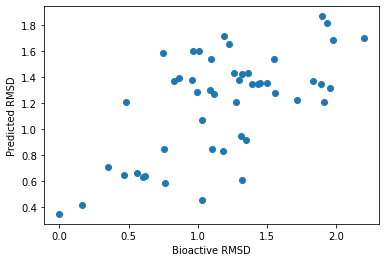

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

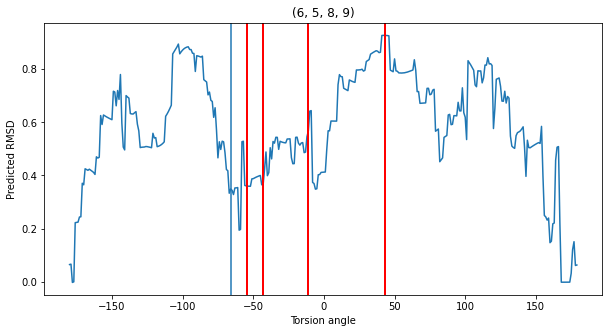

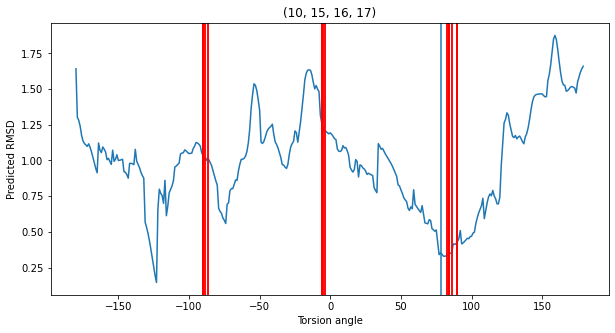

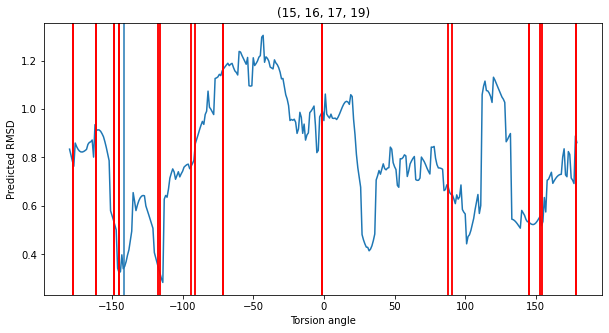

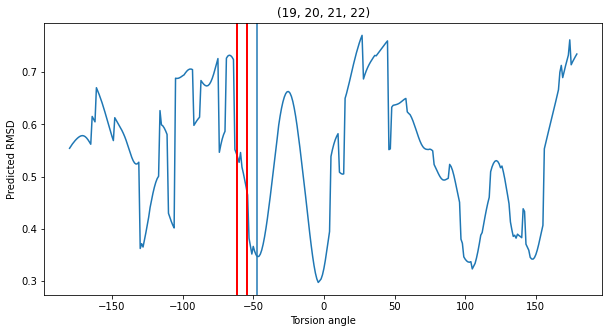

In [80]:
mol = refined_mols[1]
explore_torsion_space(mol, litschnet)


INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


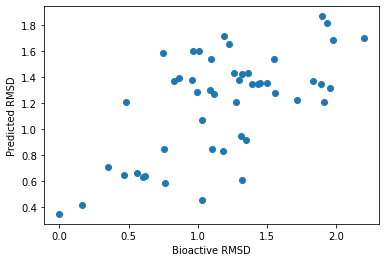

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

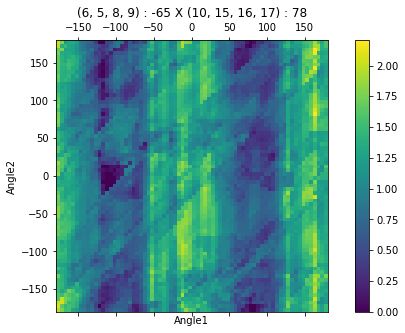

KeyboardInterrupt: 

In [82]:
mol = refined_mols[1]
explore_torsion_space_2d(mol, litschnet)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


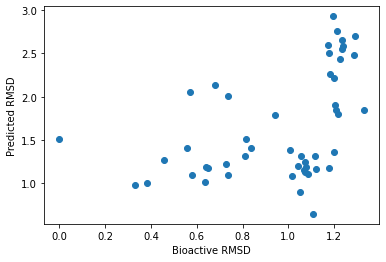

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

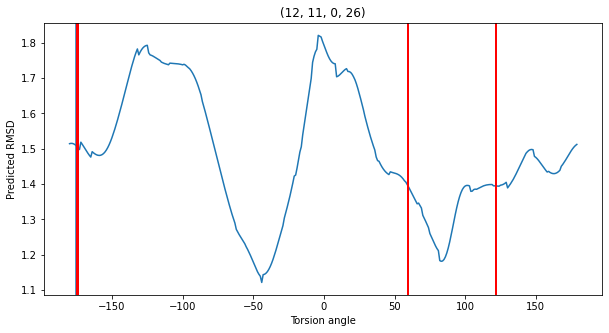

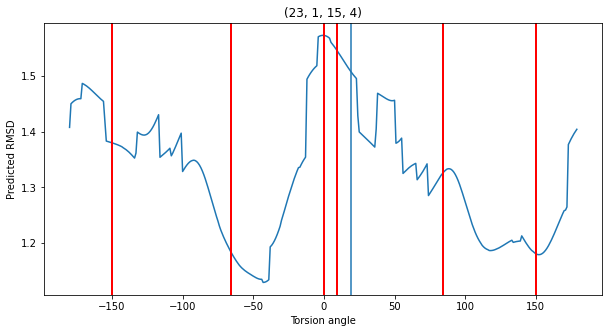

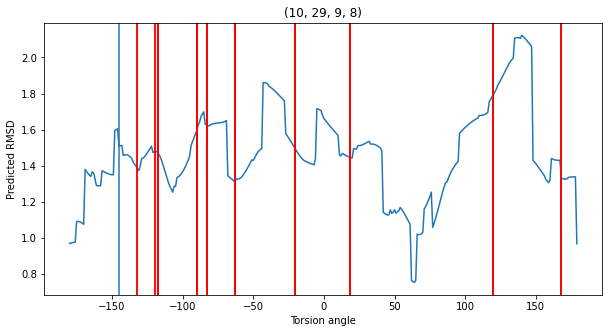

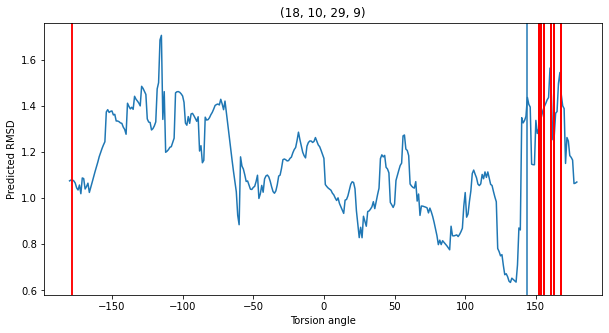

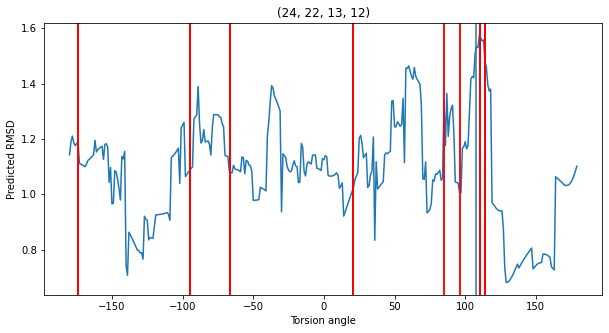

In [72]:
mol = refined_mols[2]
explore_torsion_space(mol, litschnet)

In [83]:
def scoring_function(inputs, data_list, dummy_mol, torsions) :
    conf = dummy_mol.GetConformer(0)
    for i, input in enumerate(inputs) :
        SetDihedralDeg(conf, *torsions[i], input)
    data = conf_to_data(rdkit_mol=dummy_mol, 
                        conf_id=0, 
                        bioactive_conf_ids=range(mol.GetNumConformers()), 
                        x=data_list[0].x, 
                        edge_index=data_list[0].edge_index, 
                        edge_attr=data_list[0].edge_attr, 
                        rmsd_func='ccdc')
    data_list = [data]
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch).detach().numpy()
    output = pred_rmsd[0][0]
    return output

In [84]:
from scipy.optimize import minimize

In [85]:
def ccdc_rmsd_rdkit_mol(rdkit_mol, conf_id1, conf_id2) :
    molblock1 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id1)
    molblock2 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id2)
    ccdc_mol1 = Molecule.from_string(molblock1)
    ccdc_mol2 = Molecule.from_string(molblock2)
    return MolecularDescriptors.overlay_rmsds_and_transformation(ccdc_mol1, ccdc_mol2)[1]

In [91]:
def optimize_torsions(mol) :
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    data_list = featurize_mol(mol=mol)
    dummy_mol = data_list_to_conf_ensemble(data_list, mol)
    try :
        gen_conf_id = [i for i, data in enumerate(data_list) if data.rmsd[0] > 0.01][0]

        x0 = [GetDihedralDeg(dummy_mol.GetConformer(gen_conf_id), *torsion_atoms) for torsion_atoms in torsions]
        #print(x0)

        opt = minimize(scoring_function, x0, args=(data_list, dummy_mol, torsions), method='Nelder-Mead', bounds=[(-180, 180)] * len(torsions))
        print(opt.fun)
        solution = opt.x
        #print(solution)

        new_mol = copy.deepcopy(mol)

        dummy_mol2 = copy.deepcopy(mol)
        conf = dummy_mol2.GetConformer(0)
        for i, angle in enumerate(solution) :
            SetDihedralDeg(conf, *torsions[i], angle)

        conf_id2 = new_mol.AddConformer(conf, assignId=True)
        rmsd_to_bioactive = ccdc_rmsd_rdkit_mol(new_mol, 0, conf_id2)
        print(rmsd_to_bioactive)

        gen_conf_id = new_mol.AddConformer(dummy_mol.GetConformer(gen_conf_id), assignId=True)
        rmsd_to_generated = ccdc_rmsd_rdkit_mol(new_mol, 0, gen_conf_id)
        print(rmsd_to_generated)

        rdkit_mol = new_mol

        def conf_viewer(idx):
            return MolTo3DView(rdkit_mol, idx).show()

        interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
        
        return rmsd_to_bioactive, rmsd_to_generated
        
    except :
        print('Error in generation')

In [95]:
b_rmsds = []
g_rmsds = []
for mol in refined_mols[:30] :
    b_rmsd, g_rmsd = optimize_torsions(mol)
    b_rmsds.append(b_rmsd)
    g_rmsds.append(g_rmsd)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.43301981687545776
2.3809843805202626
2.4315534712994533


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.2594074308872223
2.0126440211504972
1.8307150100751426


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.1423259973526
1.2677872598111244
1.2331650450197251


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.28852003812789917
2.271280454425718
2.2863005427905225


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.8609444499015808
1.7634834962581545
1.751377636947983


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.9213806390762329
2.1612349227317145
2.220665307462842


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.917444109916687
2.1442798308681525
2.1554964996238266


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.8801714181900024
2.2290559306318616
2.294087364200412


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
-0.0033052200451493263
1.1793681803699034
1.2128062886302393


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.31125786900520325
1.1765506644787338
1.0436335505902672


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.9973371624946594
0.0
0.2510693148326936


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.8865652680397034
0.2037940184905784
0.20992052819549167


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.2631864547729492
1.723943394669713
1.677874435747169


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
-0.002348510315641761
0.0
0.11706877702054701


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.32199209928512573
1.4791984668048153
1.5524391882619355


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.004245162010192871
0.8309200008960158
0.49072029016962443


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.1278777122497559
2.177844368011576
2.1997645406953303


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.2471455335617065
3.0873755639419183
2.8771796679145423


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.9477069973945618
1.9380854466300663
1.8603387641649227


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.27303534746170044
0.0
0.1737768326407408


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.24829885363578796
1.5298071658576076
1.4996221106407959


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
-0.0015630788402631879
0.019695034994084957
0.07365001369924952


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.4904193878173828
1.4018361228488454
1.5682775756086942


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.7338732481002808
1.250407727055158
1.0982648803635335


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.048002939671278
0.4697875902379899
0.9261163245583142


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.9680839776992798
2.3025217945041416
2.869141670585425


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.4060070216655731
0.9825878412522074
0.9600393416783214


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.8881827592849731
2.833963019200149
3.348403582282811


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.10931845009326935
0.19409309901272884
0.0344196942099953


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
-0.002183981239795685
1.4387300516089478
1.3673215481791765


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

In [96]:
np.array(b_rmsds).mean()

1.4150419949087554

In [97]:
np.array(g_rmsds).mean()

1.4538403266029911

In [ ]:
for mol in refined_mols[10:20] :
    optimize_torsions(mol)